### Libraries and Environment

In [ ]:
# 1. Libraries & Environment

import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Data Ingestion

In [ ]:
# Data Ingestion
dir_data = "/content/drive/MyDrive/Mini 4/Biz Vale/Data"
# dir_data = "/content/drive/MyDrive/Business Value/Update 1/Data"

if os.path.exists(dir_data):
    print("Directory exists.")
else:
    print("Directory does NOT exist! Check the path.")

def ingest_files(directory: str):
    # Reads all CSV files in directory, skipping the first line
    if directory[-1] != "/":
        directory += "/"
    all_files = os.listdir(directory)
    output = {}

    print(f"Directory {directory} has {len(all_files)} files:")
    for filename in all_files:
        if filename.endswith('.csv'):
            print(f"    Reading file {filename}")
            output[filename] = pd.read_csv(directory + filename, dtype=str, skiprows=1)
    return output

files_data = ingest_files(dir_data)


Directory exists.
Directory /content/drive/MyDrive/Business Value/Update 1/Data/ has 4 files:
    Reading file LoanStats3c.csv
    Reading file LoanStats3d.csv
    Reading file final_data.csv


In [ ]:
# Combining both
data_now = pd.concat(files_data.values()).reset_index(drop=True)
print("Combined shape:", data_now.shape)

Combined shape: (1311602, 191)


###  Column Selection & Initial DataFrame

In [ ]:
# Column Selection

# Base columns
cols_to_pick = [
    'id','loan_amnt','funded_amnt','term','int_rate','installment',
    'grade','emp_length','home_ownership','annual_inc','verification_status',
    'issue_d','loan_status','purpose','dti','delinq_2yrs','earliest_cr_line',
    'open_acc','pub_rec','revol_bal','revol_util','total_pymnt','last_pymnt_d',
    'recoveries'
]

# Additional columns
additional_cols_to_pick = [
    'mths_since_last_delinq',
    'acc_now_delinq',
    'bc_util',
    'mort_acc',
    'num_tl_90g_dpd_24m',
    'pub_rec_bankruptcies',
    'total_bc_limit'
]

combined_cols_to_pick = cols_to_pick + additional_cols_to_pick

final_data = data_now[combined_cols_to_pick].copy()
print("Starting with", len(final_data), "rows and", len(final_data.columns), "columns.")

Starting with 1311602 rows and 31 columns.


### Type Casting

In [ ]:
float_cols = [
    # numeric columns
    'loan_amnt','funded_amnt','installment','annual_inc','dti','revol_bal',
    'delinq_2yrs','open_acc','pub_rec','total_pymnt','recoveries',
    'mths_since_last_delinq','acc_now_delinq','bc_util','mort_acc','num_tl_90g_dpd_24m',
    'collections_12_mths_ex_med','pub_rec_bankruptcies','total_bc_limit'
]
perc_cols = ['int_rate','revol_util']
date_cols = ['issue_d','earliest_cr_line','last_pymnt_d']

cat_cols = ['term','grade','sub_grade','emp_length','home_ownership',
            'verification_status','loan_status','purpose']

# Convert float columns
for col in float_cols:
    if col in final_data.columns:
        final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

# Convert percentage columns
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    return float(str(x).rstrip('%')) if str(x).endswith('%') else float(x)

for col in perc_cols:
    if col in final_data.columns:
        final_data[col] = final_data[col].apply(clean_perc)

# Convert date columns
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime(str(x), "%b-%Y").date()

for col in date_cols:
    if col in final_data.columns:
        final_data[col] = final_data[col].apply(clean_date)

# Convert categorical columns
for col in cat_cols:
    if col in final_data.columns:
        final_data[col] = final_data[col].astype(str).str.strip().replace({'None':'', 'nan':''}, regex=True)


### Further Cleaning and Engineering

In [ ]:
# Drop rows missing required columns
required_cols = set(cols_to_pick) - set(cat_cols) - {"id"}
required_cols.add("grade")  # You specifically wanted grade non-null

n_rows_before = len(final_data)
final_data.dropna(subset=required_cols, inplace=True)
print("Removed", n_rows_before - len(final_data), "rows missing required columns.")

# Function to compute month difference
def precise_month_diff(d1, d2):
    """
    Computes the difference between two dates in 'months' with partial months included.
    1. Compute full months difference.
    2. Add a fractional part based on day difference / average days in a month (30.4375).
    """
    if pd.isnull(d1) or pd.isnull(d2):
        return np.nan
    if hasattr(d1, 'date'):
        d1 = d1.date()
    if hasattr(d2, 'date'):
        d2 = d2.date()
    sign = 1
    if d2 < d1:
        d1, d2 = d2, d1
        sign = -1
    full_months = (d2.year - d1.year) * 12 + (d2.month - d1.month)
    day_offset = d2.day - d1.day
    partial = day_offset / 30.4375
    return sign * (full_months + partial)

# Loan_length in months
final_data['loan_length'] = final_data.apply(
    lambda row: precise_month_diff(row['issue_d'], row['last_pymnt_d']),
    axis=1
)

# Remove rows where loan_length == 0
n_rows_temp = len(final_data)
final_data = final_data[final_data['loan_length'] != 0]
print("Removed", n_rows_temp - len(final_data), "rows where loan_length == 0")

Removed 655602 rows missing required columns.
Removed 1125 rows where loan_length == 0


### Create ret_PESS, ret_OPT, ret_INTa, ret_INTb, ret_INTc

In [ ]:
final_data['term_num'] = final_data['term'].str.extract('(\d+)').astype(int)

final_data['ret_PESS'] = (
    (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt']
) * (12 / final_data['term_num'])

final_data['ret_OPT'] = (
    (final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt']
) * (12 / final_data['loan_length'])
final_data.loc[final_data['ret_OPT'] < 0, 'ret_OPT'] = final_data['ret_PESS'][final_data['ret_OPT'] < 0]

def ret_method_3(T, i):
    # same code you had
    actual_installment = (final_data['total_pymnt'] - final_data['recoveries']) / final_data['loan_length']
    cash_by_end_of_loan = actual_installment * (1 - pow((1 + i), final_data['loan_length'])) / (1 - (1 + i))
    cash_by_end_of_loan += final_data['recoveries']
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow((1 + i), remaining_months)
    return (12 / T) * ((final_return - final_data['funded_amnt']) / final_data['funded_amnt'])

final_data['ret_INTa'] = ret_method_3(5 * 12, 0.001)
final_data['ret_INTb'] = ret_method_3(5 * 12, 0.0025)
final_data['ret_INTc'] = ret_method_3(5 * 12, 0.005)

### Single and multiple variable summaries and visualizations

In [ ]:
num_cols = final_data.select_dtypes(include=["float64","int64"]).columns
display(final_data[num_cols].describe())  # your summary

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,pub_rec_bankruptcies,total_bc_limit,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
count,654875.000000,654875.000000,654875.000000,654875.000000,6.548750e+05,654875.000000,654875.000000,654875.000000,654875.000000,6.548750e+05,...,654875.000000,654875.000000,6.548750e+05,654875.000000,654875.000000,654875.000000,654875.000000,654875.000000,654875.000000,654875.000000
mean,15108.384463,15108.384463,13.014309,442.067498,7.619750e+04,18.755010,0.346240,11.851530,0.229850,1.727145e+04,...,0.094352,0.133858,2.127273e+04,26.979824,43.708989,0.025754,0.055497,0.028868,0.044830,0.074072
std,8523.464606,8523.464606,4.355573,244.839066,6.757381e+04,8.600413,0.917085,5.505148,0.634324,2.325850e+04,...,0.511507,0.382663,2.128784e+04,14.632412,11.206579,0.072266,0.088815,0.056508,0.059419,0.064930
min,1000.000000,1000.000000,5.320000,14.010000,1.200000e+03,0.000000,0.000000,1.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,1.000000,36.000000,-0.327964,-0.327964,-0.196586,-0.196276,-0.195698
25%,8450.000000,8450.000000,9.670000,264.460000,4.600000e+04,12.380000,0.000000,8.000000,0.000000,6.434000e+03,...,0.000000,0.000000,7.500000e+03,15.000000,36.000000,0.021556,0.042935,0.025755,0.043320,0.074920
50%,13775.000000,13775.000000,12.690000,385.140000,6.500000e+04,18.240000,0.000000,11.000000,0.000000,1.189500e+04,...,0.000000,0.000000,1.470000e+04,27.000000,36.000000,0.042998,0.071392,0.039051,0.056440,0.088725
75%,20000.000000,20000.000000,15.610000,578.690000,9.000000e+04,24.760000,0.000000,15.000000,0.000000,2.110100e+04,...,0.000000,0.000000,2.770000e+04,36.000000,60.000000,0.066028,0.103411,0.055783,0.072960,0.105017
max,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,999.000000,39.000000,90.000000,86.000000,2.904836e+06,...,39.000000,12.000000,1.090700e+06,77.000000,60.000000,0.195754,1.608404,0.204419,0.223935,0.259119


In [ ]:
# Individual Summary Statistic for numeric columns
for col in num_cols:
    print(f"\nSummary for {col}:")
    print(final_data[col].describe())


Summary for loan_amnt:
count    654875.000000
mean      15108.384463
std        8523.464606
min        1000.000000
25%        8450.000000
50%       13775.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Summary for funded_amnt:
count    654875.000000
mean      15108.384463
std        8523.464606
min        1000.000000
25%        8450.000000
50%       13775.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64

Summary for int_rate:
count    654875.000000
mean         13.014309
std           4.355573
min           5.320000
25%           9.670000
50%          12.690000
75%          15.610000
max          28.990000
Name: int_rate, dtype: float64

Summary for installment:
count    654875.000000
mean        442.067498
std         244.839066
min          14.010000
25%         264.460000
50%         385.140000
75%         578.690000
max        1445.460000
Name: installment, dtype: float64

Summary for annual_inc:
count    

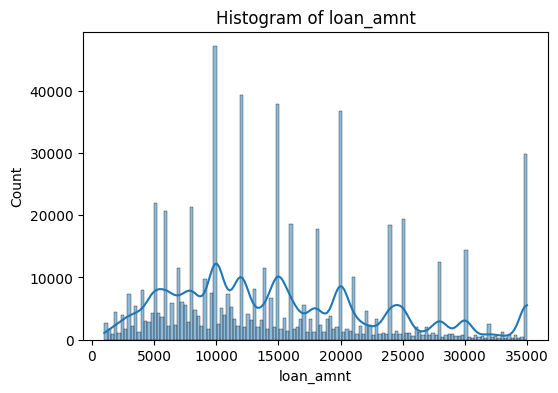

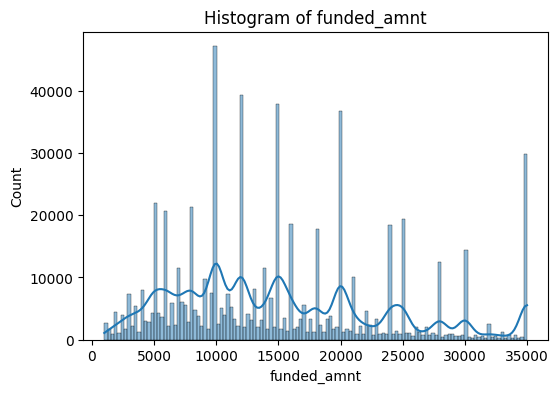

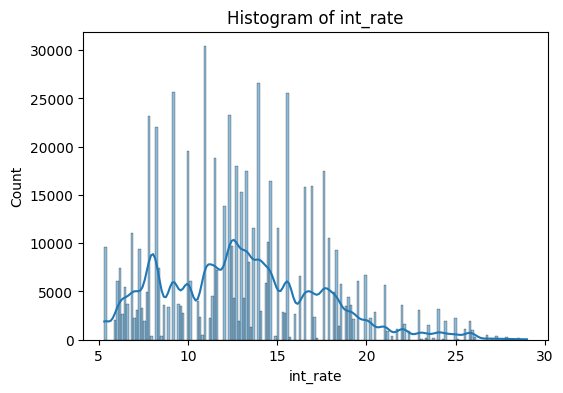

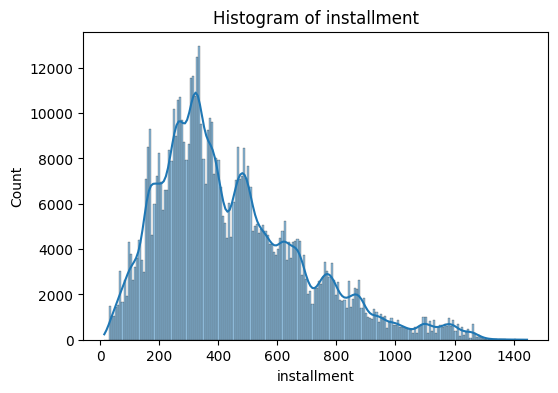

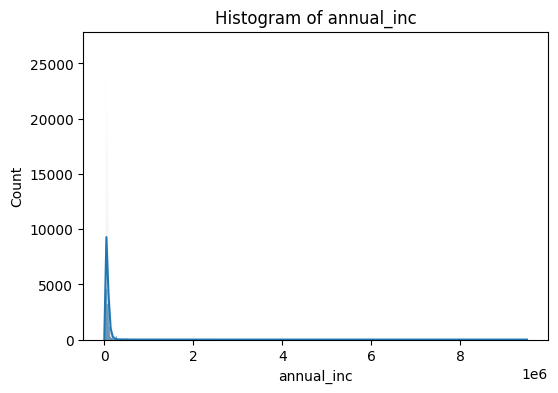

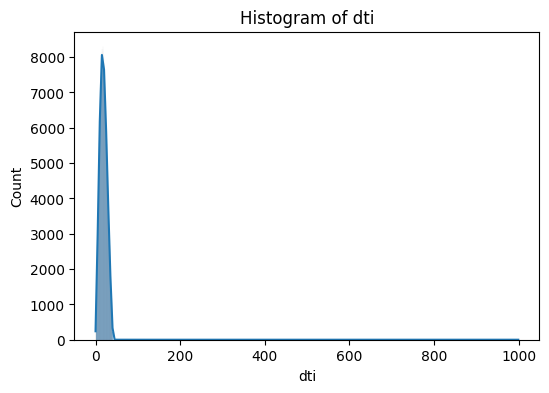

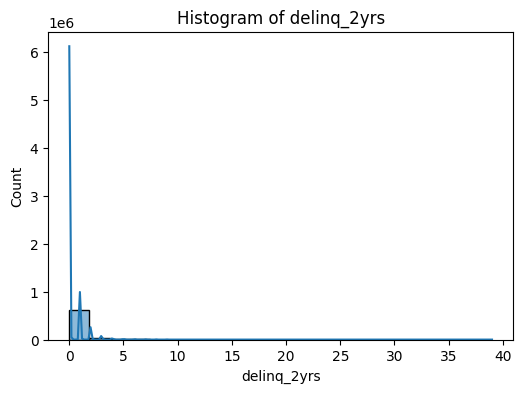

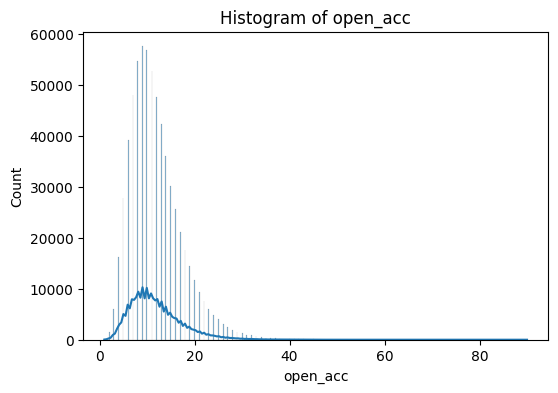

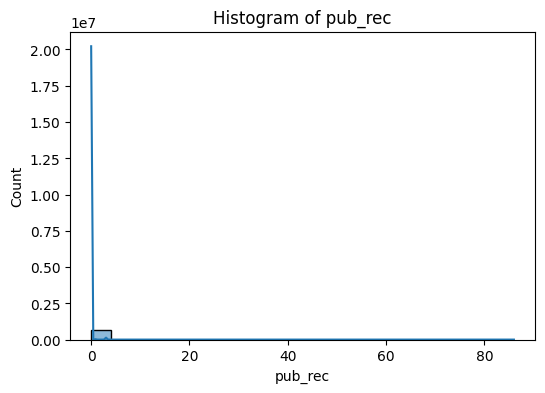

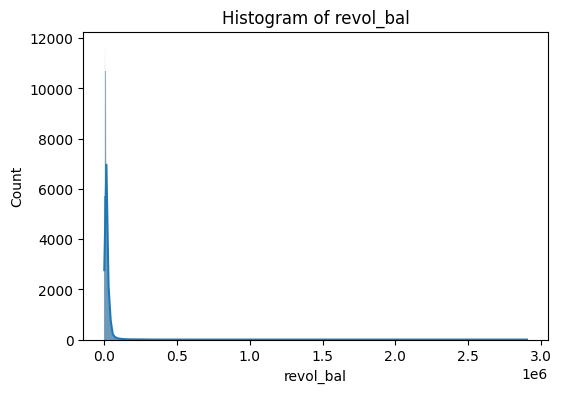

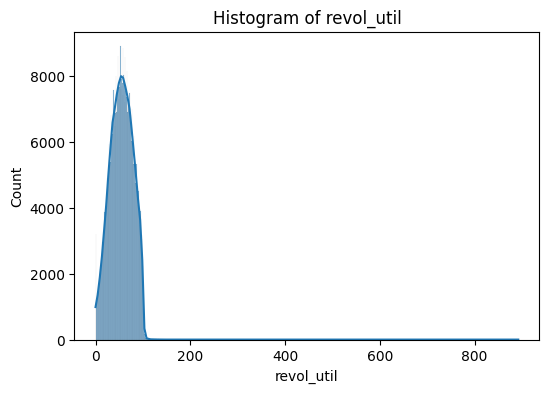

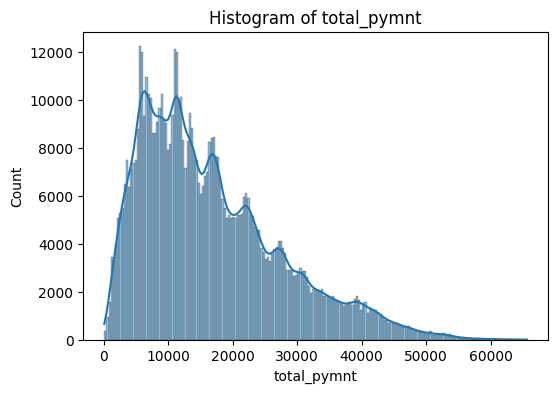

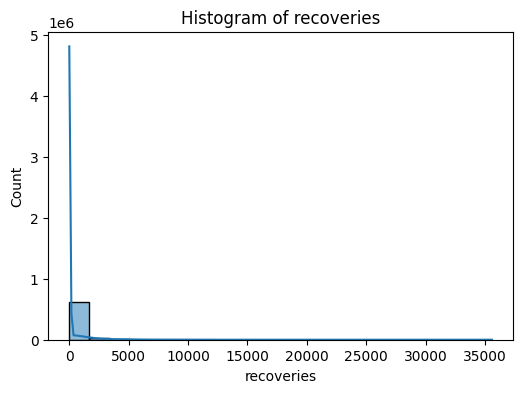

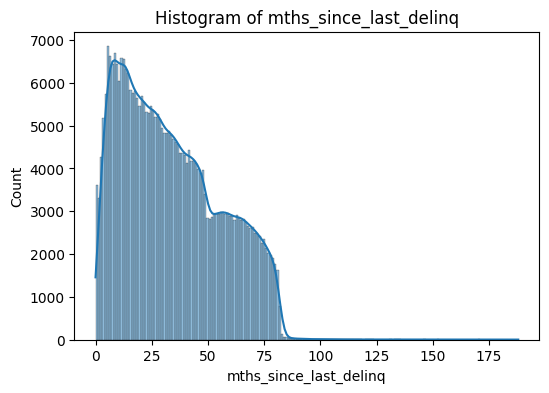

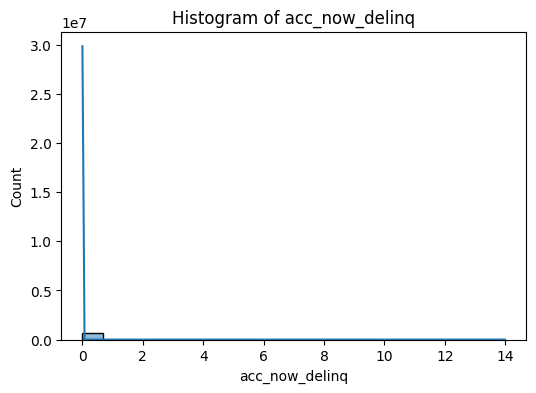

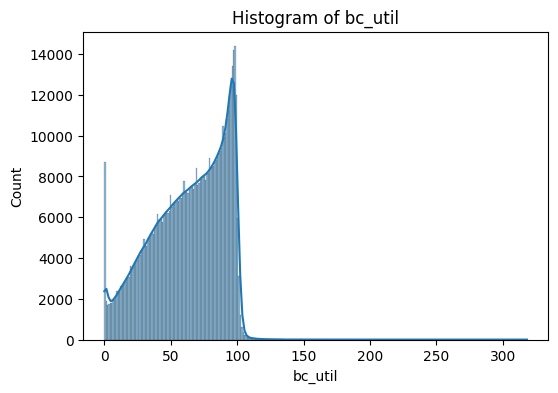

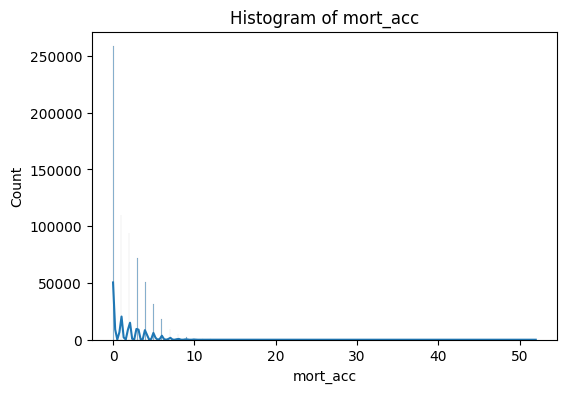

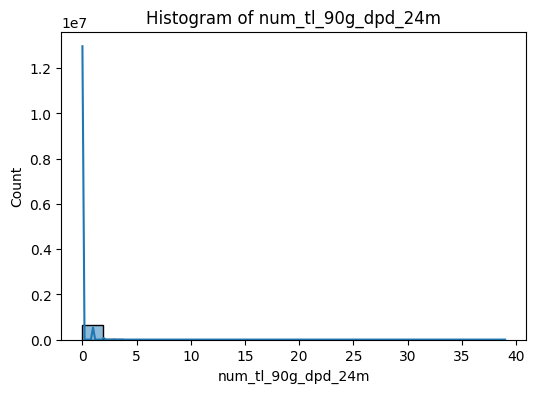

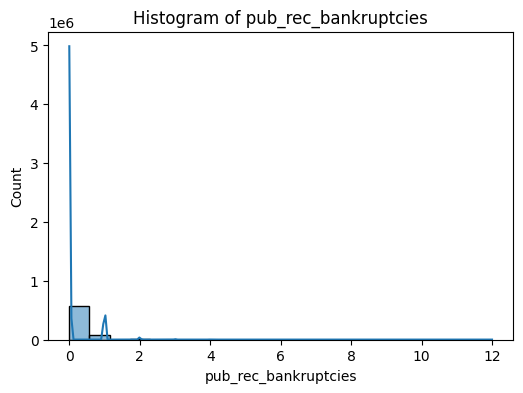

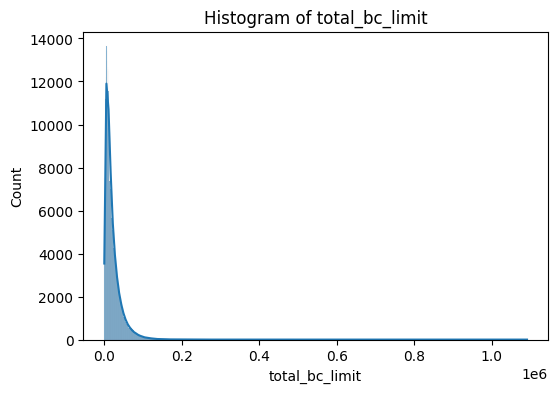

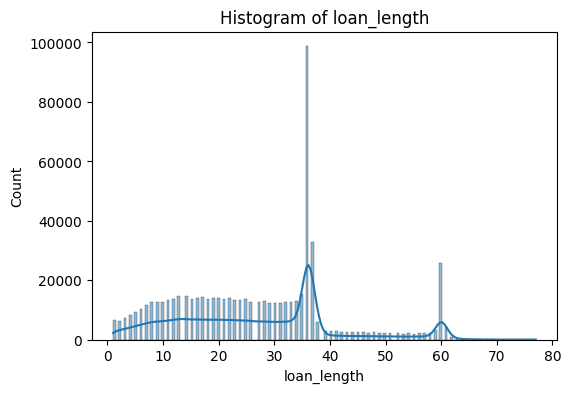

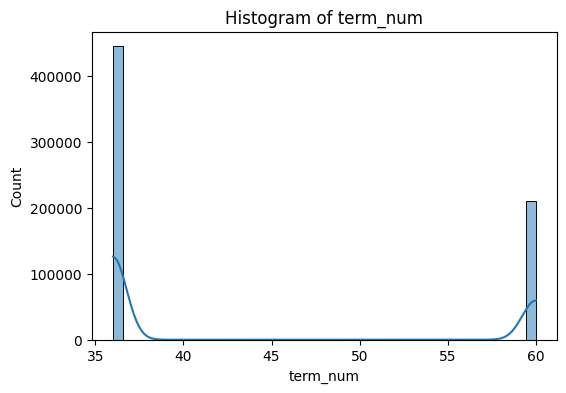

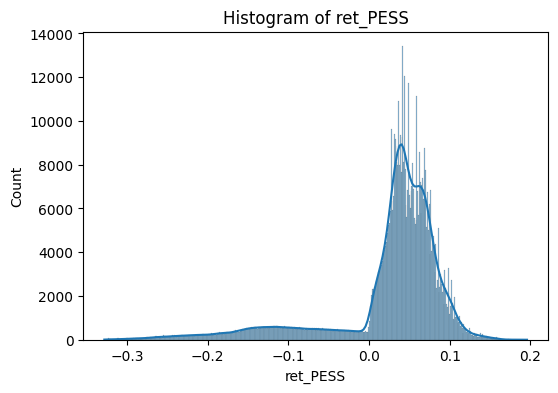

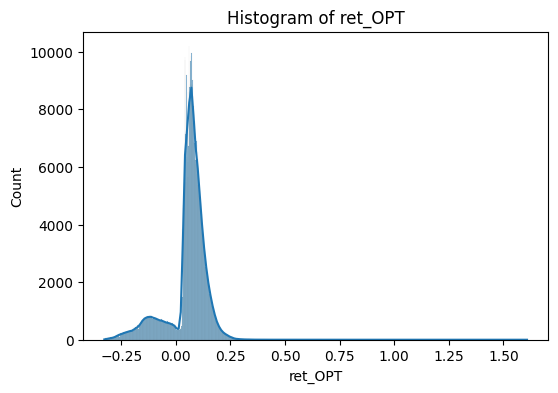

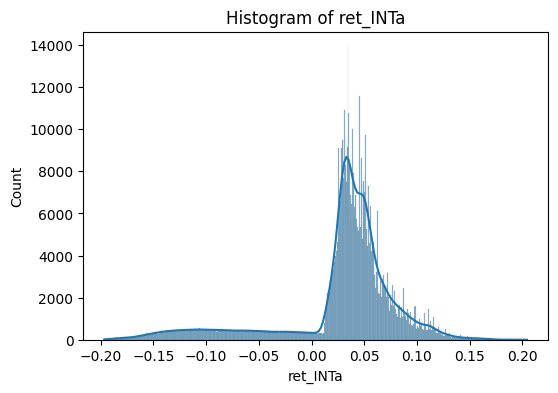

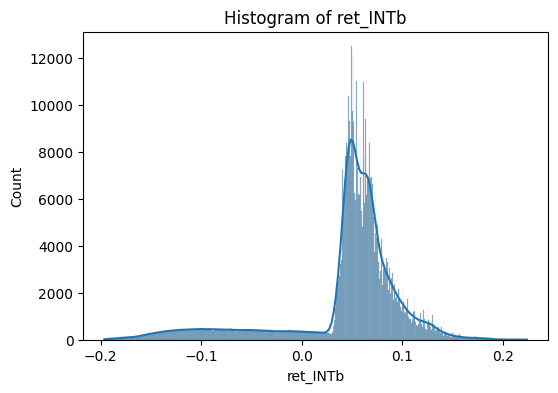

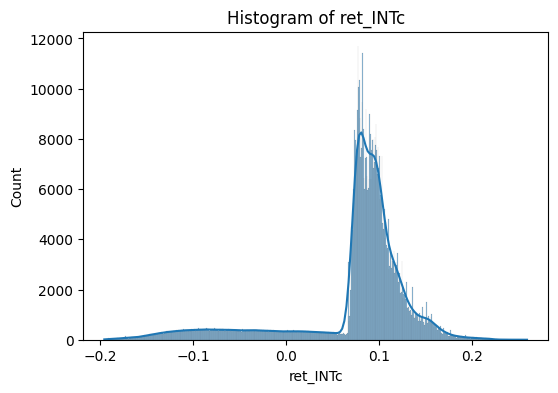

In [ ]:
# Histograms
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data=final_data, x=col, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

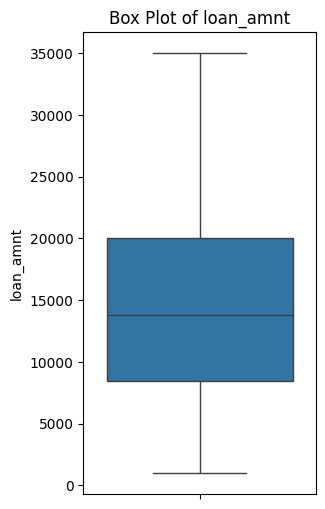

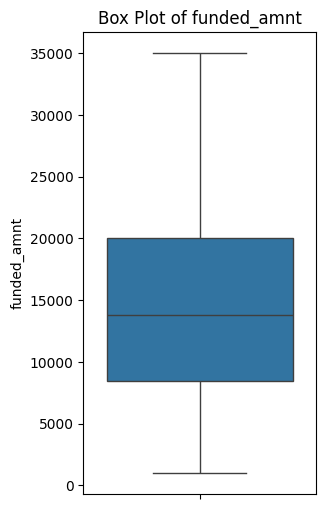

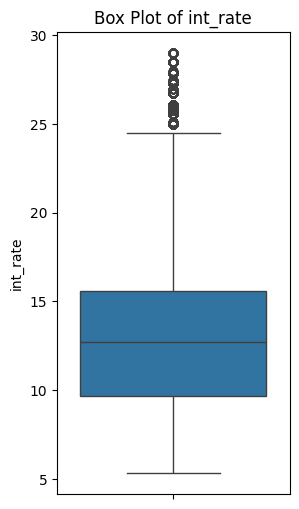

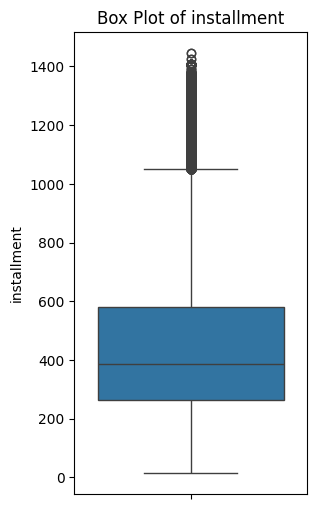

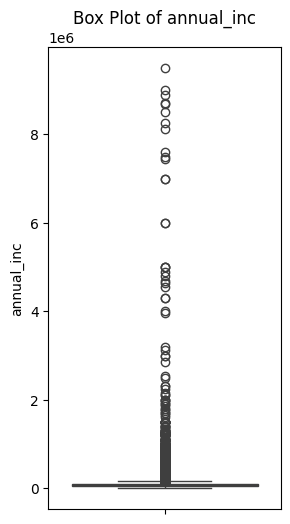

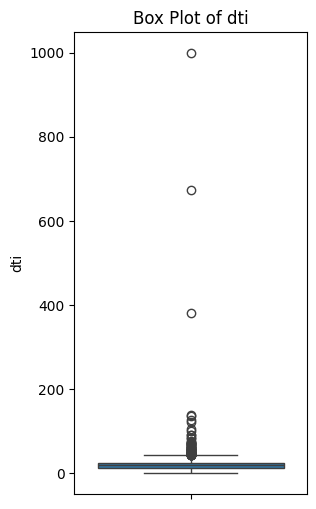

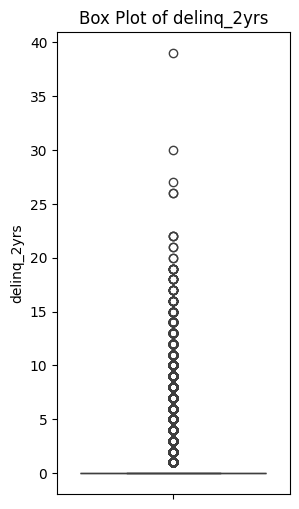

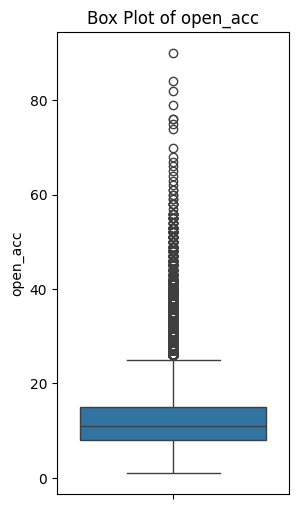

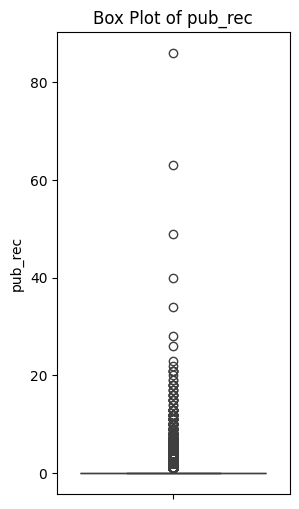

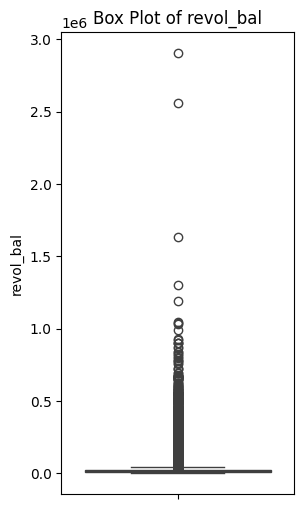

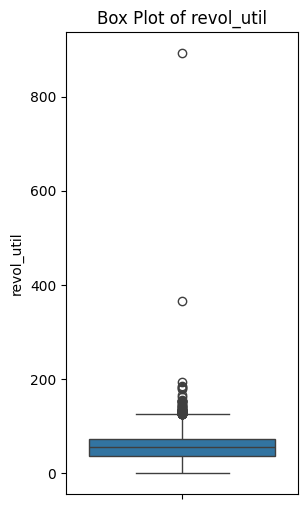

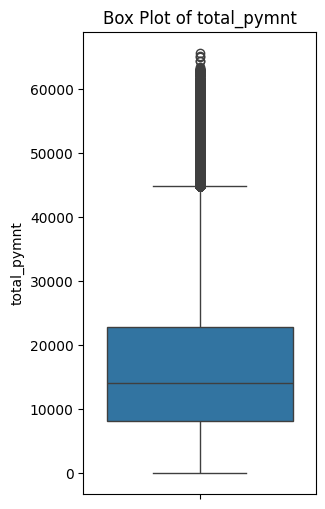

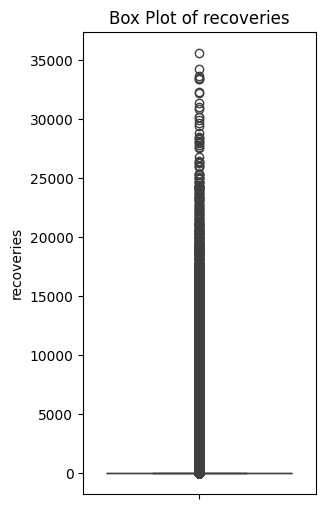

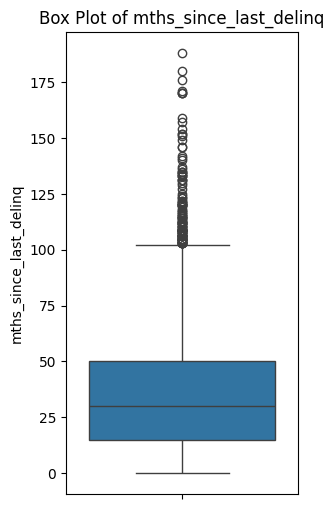

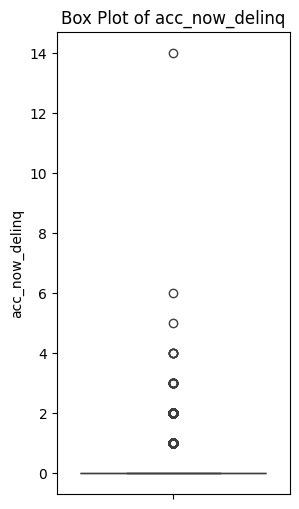

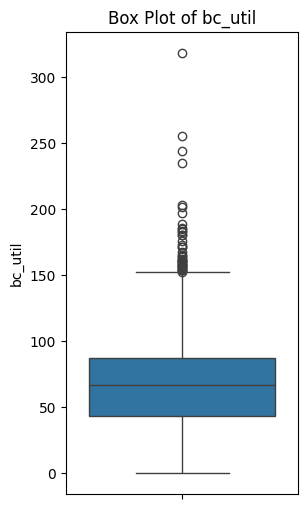

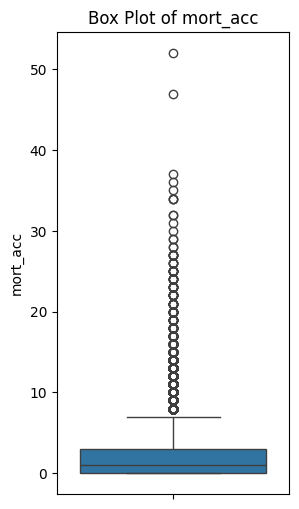

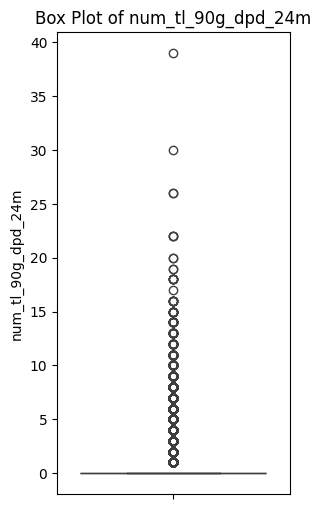

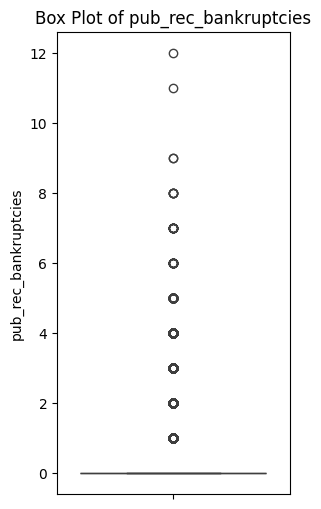

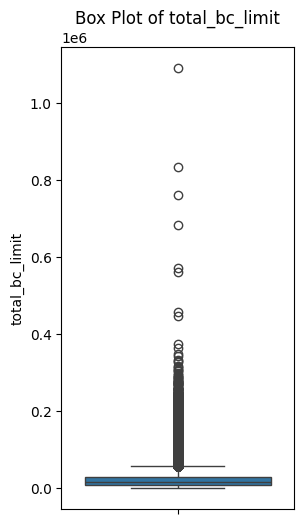

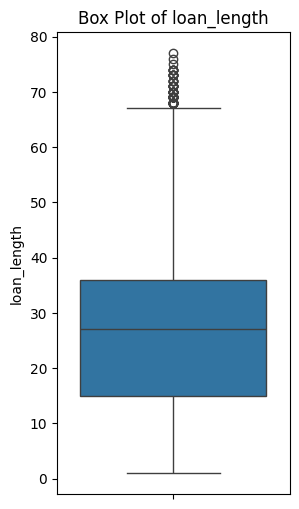

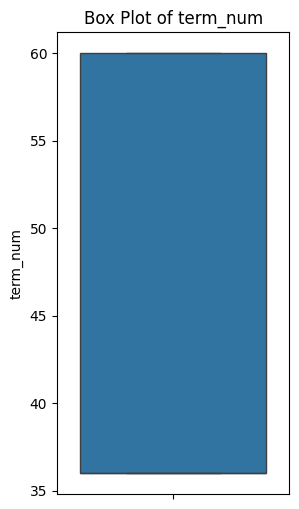

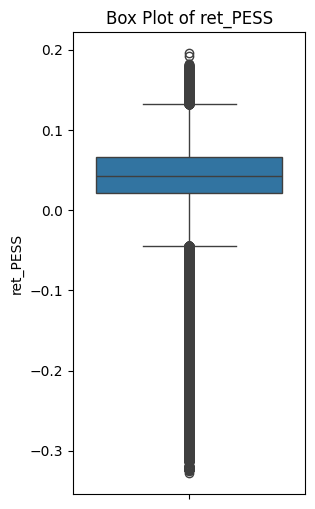

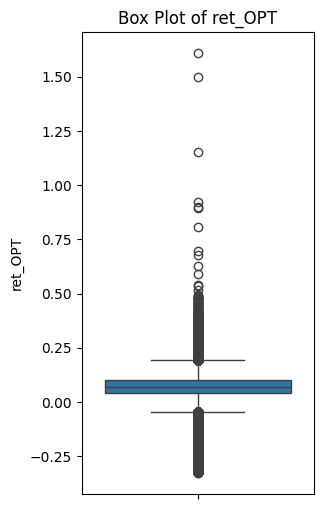

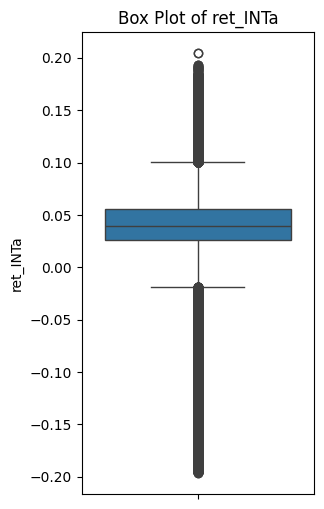

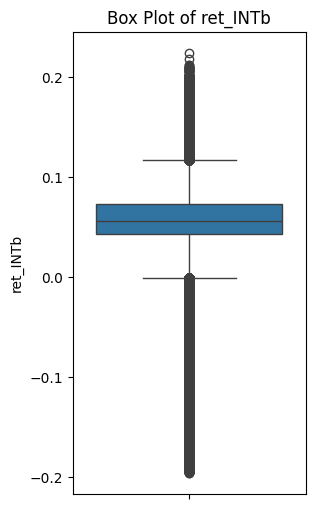

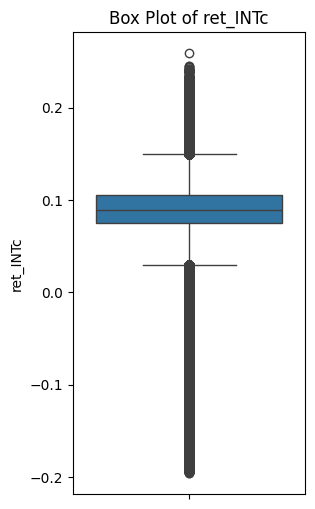

In [ ]:
# Boxplots
for col in num_cols:
    plt.figure(figsize=(3,6))
    sns.boxplot(y=final_data[col])
    plt.title(f"Box Plot of {col}")
    plt.ylabel(col)
    plt.show()

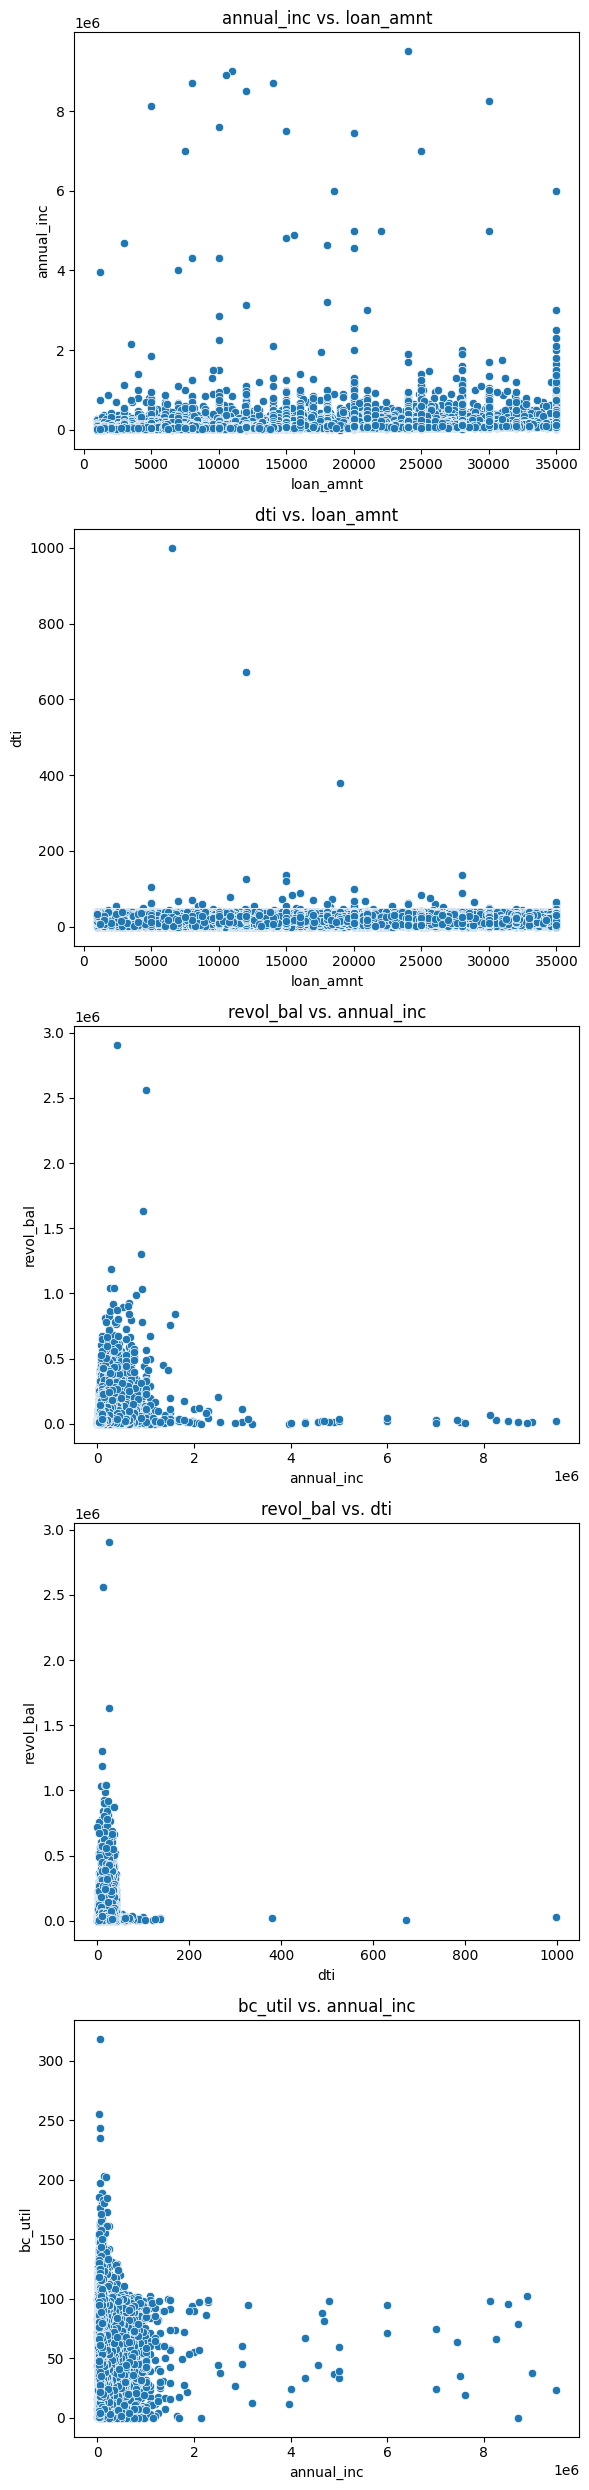

In [ ]:
# Scatter plots
pairs_to_plot = [
    ("loan_amnt","annual_inc"),
    ("loan_amnt","dti"),
    ("annual_inc","revol_bal"),
    ("dti","revol_bal"),
    ("annual_inc","bc_util")
]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 25))
for ax, (x_col, y_col) in zip(axes, pairs_to_plot):
    sns.scatterplot(data=final_data, x=x_col, y=y_col, ax=ax)
    ax.set_title(f"{y_col} vs. {x_col}")
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
plt.tight_layout()
plt.show()

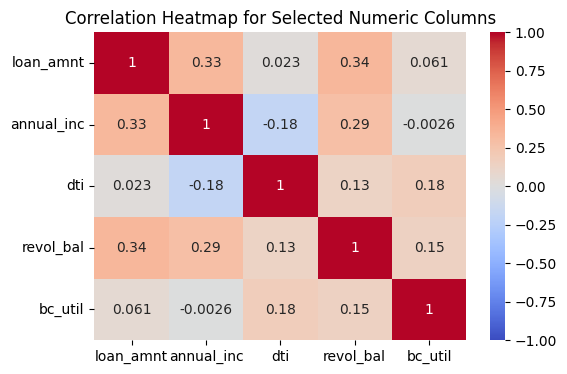

In [ ]:
# Correlation Heatmap
cols_of_interest = ["loan_amnt","annual_inc","dti","revol_bal","bc_util"]
corr_matrix = final_data[cols_of_interest].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Selected Numeric Columns")
plt.show()


In [ ]:
# Grouped Descriptive Stats
cat_col = 'grade'
for col in num_cols:
    print(f"\nGrouped Descriptive Statistics for {col} by {cat_col}:")
    grouped_stats = final_data.groupby(cat_col)[col].describe()
    print(grouped_stats)


Grouped Descriptive Statistics for loan_amnt by grade:
          count          mean          std     min      25%      50%      75%  \
grade                                                                           
A      109284.0  14629.413729  7557.293445  1000.0   8650.0  13000.0  20000.0   
B      179160.0  14040.800123  8035.061881  1000.0   8000.0  12000.0  20000.0   
C      186621.0  14652.215989  8653.899450  1000.0   8000.0  12600.0  20000.0   
D      105247.0  15987.696561  9054.230189  1000.0   9450.0  14900.0  21600.0   
E       54817.0  17998.476294  8983.684402  1000.0  11200.0  16525.0  24500.0   
F       15935.0  18786.832444  9166.252972  1000.0  12000.0  17925.0  25512.5   
G        3811.0  20134.800577  8601.963686  1000.0  12987.5  19050.0  27050.0   

           max  
grade           
A      35000.0  
B      35000.0  
C      35000.0  
D      35000.0  
E      35000.0  
F      35000.0  
G      35000.0  

Grouped Descriptive Statistics for funded_amnt by grade:
   

In [ ]:
pd.crosstab(final_data['grade'], final_data['home_ownership'])

home_ownership,ANY,MORTGAGE,OWN,RENT
grade,,,,
A,0,61740,11432,36112
B,1,90400,18501,70258
C,1,89319,19353,77948
D,1,49871,11028,44347
E,0,26225,5943,22649
F,0,7440,1810,6685
G,0,1794,433,1584


In [ ]:
pd.crosstab(final_data['grade'], final_data['emp_length'])

emp_length,,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
grade,,,,,,,,,,,,
A,5335,6896,37282,9757,8736,6370,6496,4674,5096,5575,4218,8849
B,9669,11534,60574,15894,14201,10350,10263,7705,8519,9070,7250,14131
C,10362,12194,62456,16463,14675,10700,10735,8190,8902,9455,7370,15119
D,6405,6670,35012,9105,8131,6235,6063,4633,5224,5337,4212,8220
E,2931,3438,18483,4859,4280,3146,3188,2407,2684,2818,2251,4332
F,842,971,5377,1418,1202,920,925,782,781,861,635,1221
G,177,255,1258,339,314,213,201,194,216,189,165,290


In [ ]:
pd.crosstab(final_data['grade'], final_data['purpose'])

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
grade,,,,,,,,,,,,,,
A,1118,41987,54737,0,6718,48,2084,414,60,1799,9,110,200,0
B,1546,53875,101803,1,10088,186,2980,1333,440,5682,31,481,710,4
C,1443,38678,116517,0,10570,473,3108,2114,1217,9685,104,1412,1296,4
D,677,15496,69240,0,6010,546,1713,1334,1079,6704,100,1564,782,2
E,332,5982,36968,0,3438,493,932,705,610,3744,66,1238,309,0
F,115,1083,10437,0,1090,283,337,265,260,1374,29,563,99,0
G,26,164,2332,0,268,137,85,60,56,414,6,245,16,2


In [ ]:
pd.crosstab(final_data['home_ownership'], final_data['loan_status'])

loan_status,Charged Off,Fully Paid
home_ownership,,
ANY,0,3
MORTGAGE,52807,273982
OWN,12996,55504
RENT,55750,203833


In [ ]:
pd.crosstab(final_data['purpose'], final_data['loan_status'])

loan_status,Charged Off,Fully Paid
purpose,,
car,771,4486
credit_card,24412,132853
debt_consolidation,77417,314617
educational,0,1
home_improvement,6448,31734
house,513,1653
major_purchase,2021,9218
medical,1221,5004
moving,842,2880


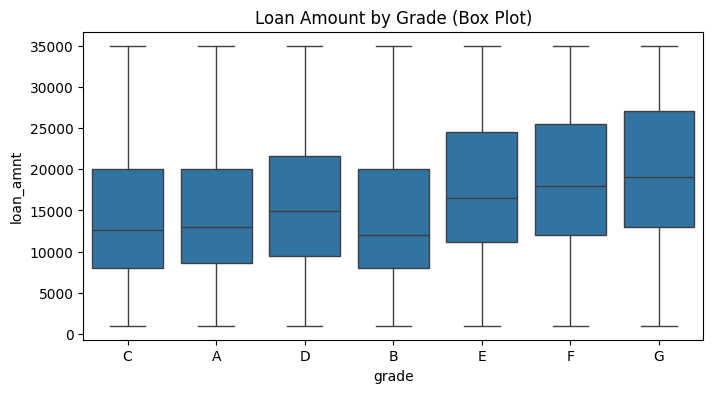

In [ ]:
# Loan_amnt across different grades
plt.figure(figsize=(8, 4))
sns.boxplot(x="grade", y="loan_amnt", data=final_data)
plt.title("Loan Amount by Grade (Box Plot)")
plt.show()

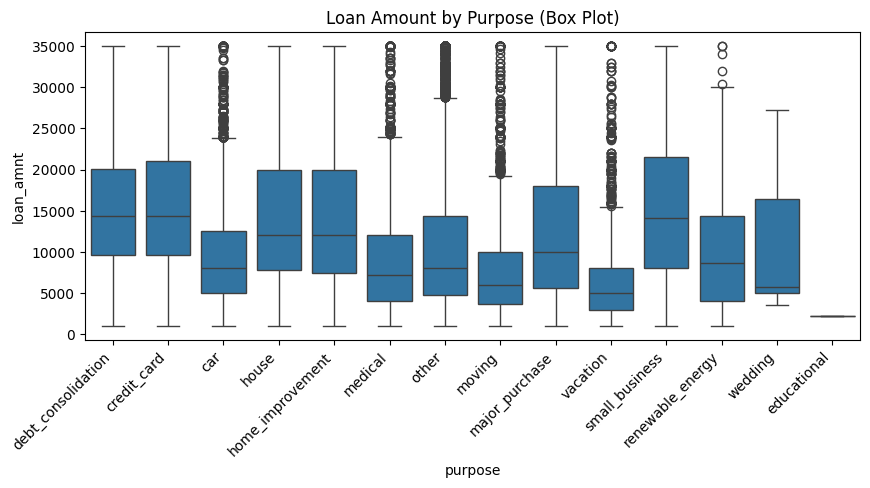

In [ ]:
# Loan Amount by Purpose
plt.figure(figsize=(10, 4))
sns.boxplot(x="purpose", y="loan_amnt", data=final_data)
plt.title("Loan Amount by Purpose (Box Plot)")
plt.xticks(rotation=45, ha="right")
plt.show()

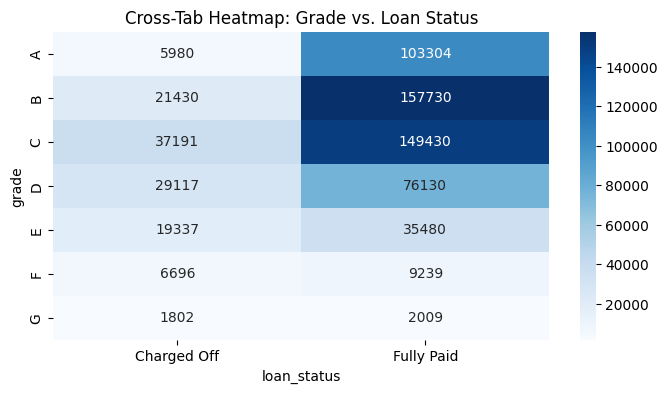

In [ ]:
#  Grade vs. Loan Status
ctab = pd.crosstab(final_data['grade'], final_data['loan_status'])

plt.figure(figsize=(8, 4))
sns.heatmap(ctab, annot=True, fmt="d", cmap="Blues")
plt.title("Cross-Tab Heatmap: Grade vs. Loan Status")
plt.show()

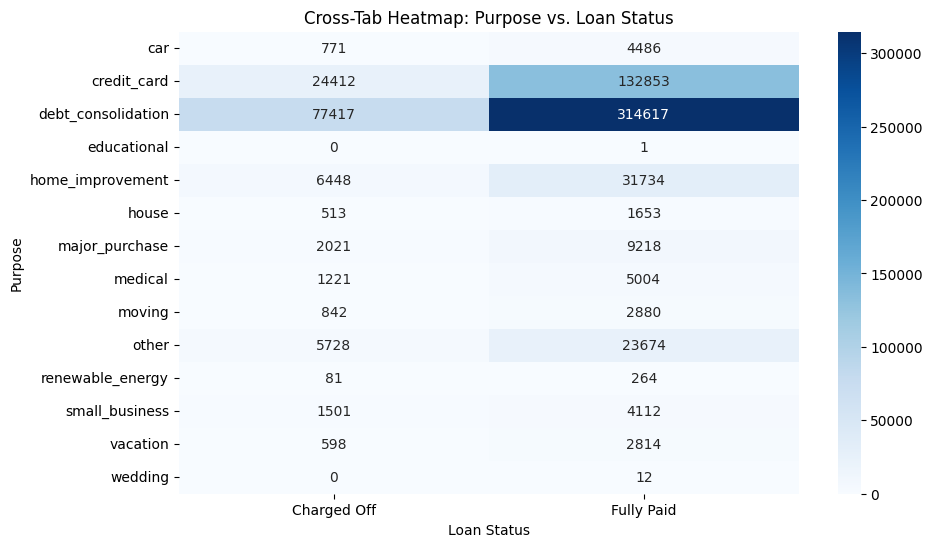

In [ ]:
# Purpose vs Loan Status
ctab = pd.crosstab(final_data['purpose'], final_data['loan_status'])

plt.figure(figsize=(10, 6))
sns.heatmap(ctab, annot=True, fmt="d", cmap="Blues")
plt.title("Cross-Tab Heatmap: Purpose vs. Loan Status")
plt.ylabel("Purpose")
plt.xlabel("Loan Status")
plt.show()

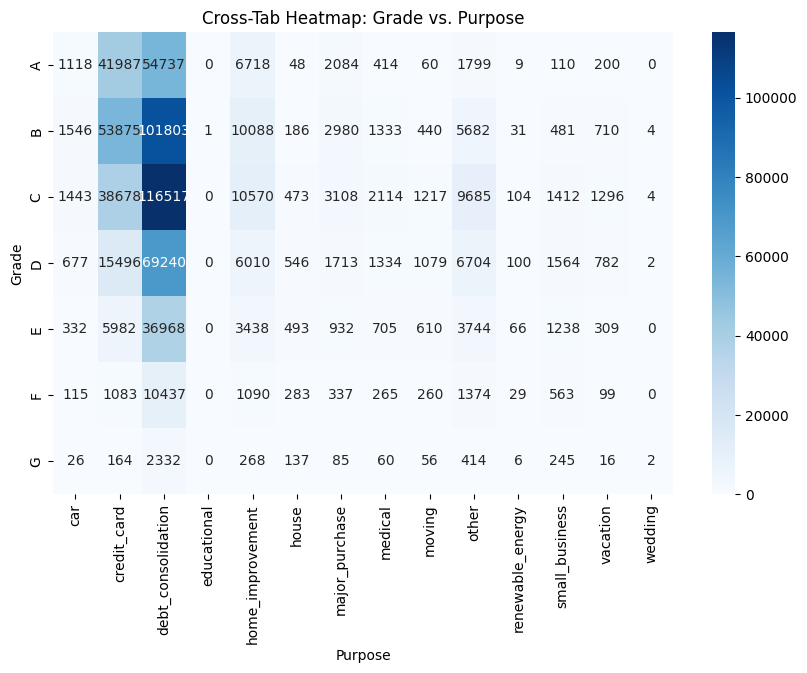

In [ ]:
# Grade vs Purpose
ctab = pd.crosstab(final_data['grade'], final_data['purpose'])

plt.figure(figsize=(10, 6))
sns.heatmap(ctab, annot=True, fmt="d", cmap="Blues")
plt.title("Cross-Tab Heatmap: Grade vs. Purpose")
plt.ylabel("Grade")
plt.xlabel("Purpose")
plt.show()

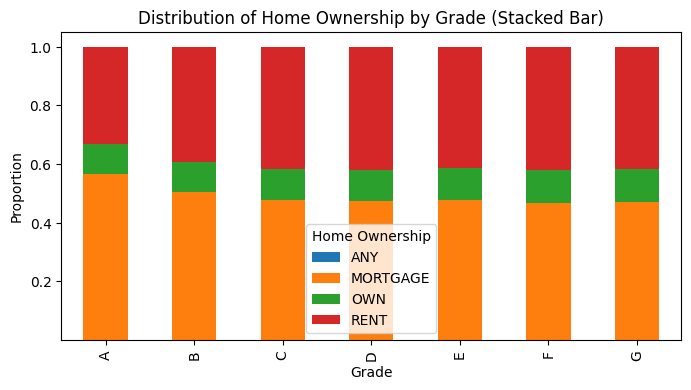

In [ ]:
# Proportion of each home ownership type within each grade
ctab = pd.crosstab(final_data['grade'], final_data['home_ownership'], normalize='index')

ctab.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Distribution of Home Ownership by Grade (Stacked Bar)")
plt.xlabel("Grade")
plt.ylabel("Proportion")
plt.legend(title="Home Ownership")
plt.show()

### Further Cleaning

In [ ]:
final_clean_data = final_data.copy()

In [ ]:
# Column Types
for col in final_clean_data.columns:
    print(f"{col}: {final_clean_data[col].dtype}")

id: object
loan_amnt: float64
funded_amnt: float64
term: object
int_rate: float64
installment: float64
grade: object
emp_length: object
home_ownership: object
annual_inc: float64
verification_status: object
issue_d: object
loan_status: object
purpose: object
dti: float64
delinq_2yrs: float64
earliest_cr_line: object
open_acc: float64
pub_rec: float64
revol_bal: float64
revol_util: float64
total_pymnt: float64
last_pymnt_d: object
recoveries: float64
mths_since_last_delinq: float64
acc_now_delinq: float64
bc_util: float64
mort_acc: float64
num_tl_90g_dpd_24m: float64
pub_rec_bankruptcies: float64
total_bc_limit: float64
loan_length: float64
term_num: int64
ret_PESS: float64
ret_OPT: float64
ret_INTa: float64
ret_INTb: float64
ret_INTc: float64


### Dropping date columns

In [ ]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d"]

final_clean_data.drop(columns=date_cols, inplace=True, errors="ignore")

print("Dropped potential date columns:", date_cols)

Dropped potential date columns: ['issue_d', 'earliest_cr_line', 'last_pymnt_d']


In [ ]:
#Checkin NaN values
null_counts = final_clean_data.isnull().sum()

cols_with_nans = null_counts[null_counts > 0]
print("\nColumns with NaN values:")
print(cols_with_nans)


Columns with NaN values:
id                        654875
mths_since_last_delinq    318953
bc_util                     6526
dtype: int64


In [ ]:
# Dealing with NaN values

# "id" column
final_clean_data.drop(columns=["id"], inplace=True, errors="ignore")

# mths_since_last_delinq
if "mths_since_last_delinq" in final_clean_data.columns:
    final_clean_data["mths_since_last_delinq"] = (
        final_clean_data["mths_since_last_delinq"].fillna(0)
    )
    print("Replaced NaN with 0 in mths_since_last_delinq.")

# bc_util
if "bc_util" in final_clean_data.columns:
    before_count = len(final_clean_data)
    final_clean_data.dropna(subset=["bc_util"], inplace=True)
    after_count = len(final_clean_data)
    print(f"Dropped {before_count - after_count} rows where bc_util was NaN.")


Replaced NaN with 0 in mths_since_last_delinq.
Dropped 6526 rows where bc_util was NaN.


In [ ]:
#Checkin NaN values
null_counts = final_clean_data.isnull().sum()

cols_with_nans = null_counts[null_counts > 0]
print("\nColumns with NaN values:")
print(cols_with_nans)


Columns with NaN values:
Series([], dtype: int64)


## Standardizing data

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_cols = final_clean_data.select_dtypes(include=["float64", "int64"]).columns

# Scaler
scaler = StandardScaler()

# Fit and transform
final_clean_data[numeric_cols] = scaler.fit_transform(final_clean_data[numeric_cols])

print("Standardized all numeric columns in final_clean_data:")
print(numeric_cols)


Standardized all numeric columns in final_clean_data:
Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
       'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_pymnt', 'recoveries', 'mths_since_last_delinq', 'acc_now_delinq',
       'bc_util', 'mort_acc', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies',
       'total_bc_limit', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT',
       'ret_INTa', 'ret_INTb', 'ret_INTc'],
      dtype='object')


In [ ]:
final_clean_data.head(5)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,pub_rec_bankruptcies,total_bc_limit,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,-0.015922,-0.015922,60 months,-0.139502,-0.433496,C,10+ years,RENT,0.025600,Source Verified,...,-0.183612,-0.349885,-0.539248,-0.614424,1.452334,0.085523,0.573838,0.266647,0.307802,0.375695
1,-0.555773,-0.555773,36 months,-1.380513,-0.497063,A,8 years,MORTGAGE,-0.270062,Not Verified,...,-0.183612,-0.349885,-0.398309,-0.477748,-0.688547,-2.038397,-1.993469,-1.688693,-1.704253,-1.723598
2,-0.878510,-0.878510,36 months,0.152365,-0.745777,C,< 1 year,RENT,-0.388328,Source Verified,...,-0.183612,-0.349885,-0.778845,-1.297799,-0.688547,-3.596589,-3.261414,-2.938255,-2.974510,-3.022510
3,-0.274112,-0.274112,60 months,0.952127,-0.505234,D,10+ years,MORTGAGE,0.720408,Verified,...,-0.183612,-0.349885,-0.802335,2.050740,1.452334,1.021437,0.555415,1.418113,1.330947,1.181620
4,0.738109,0.738109,60 months,0.595911,0.300716,D,6 years,RENT,-0.184320,Source Verified,...,-0.183612,-0.349885,-0.304349,-0.682761,1.452334,0.172178,0.893213,0.385377,0.432970,0.511391


### Understanding Loan Grades


=== Default vs. Non-default by Grade (Counts) ===
default_ind       0       1     All
grade                              
A            102840    5945  108785
B            156492   21294  177786
C            147873   36819  184692
D             75037   28770  103807
E             34858   19081   53939
F              9057    6568   15625
G              1952    1763    3715
All          528109  120240  648349

=== Default Rate (%) by Grade ===
grade
A     5.464908
B    11.977321
C    19.935352
D    27.714894
E    35.375146
F    42.035200
G    47.456258
Name: default_ind, dtype: float64


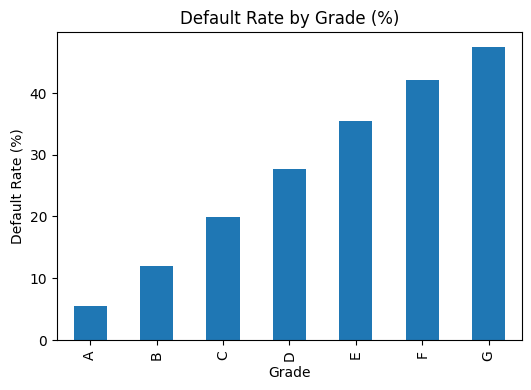

In [ ]:
# DEFAULT RATE BY GRADE
default_statuses = ["Charged Off", "Default"]
final_clean_data["default_ind"] = final_clean_data["loan_status"].isin(default_statuses).astype(int)

# Cross-tab to see counts of default vs. non-default by grade
default_crosstab = pd.crosstab(final_clean_data["grade"], final_clean_data["default_ind"], margins=True)
print("\n=== Default vs. Non-default by Grade (Counts) ===")
print(default_crosstab)

# Default rate (percentage) by grade
default_rate_by_grade = final_clean_data.groupby("grade")["default_ind"].mean() * 100
print("\n=== Default Rate (%) by Grade ===")
print(default_rate_by_grade)

# Bar plot of default rate by grade
plt.figure(figsize=(6,4))
default_rate_by_grade.plot(kind="bar")
plt.title("Default Rate by Grade (%)")
plt.ylabel("Default Rate (%)")
plt.xlabel("Grade")
plt.show()


=== Mean ret_PESS by Grade ===
grade
A   -0.029514
B    0.027094
C    0.018406
D    0.002149
E   -0.054714
F   -0.098313
G   -0.199611
Name: ret_PESS, dtype: float64


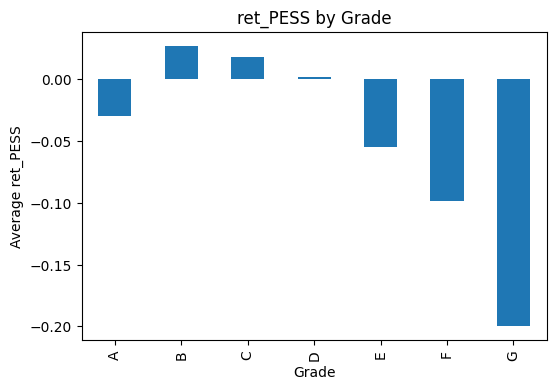


=== Mean ret_OPT by Grade ===
grade
A   -0.191546
B   -0.053203
C    0.031225
D    0.107765
E    0.154470
F    0.254336
G    0.278995
Name: ret_OPT, dtype: float64


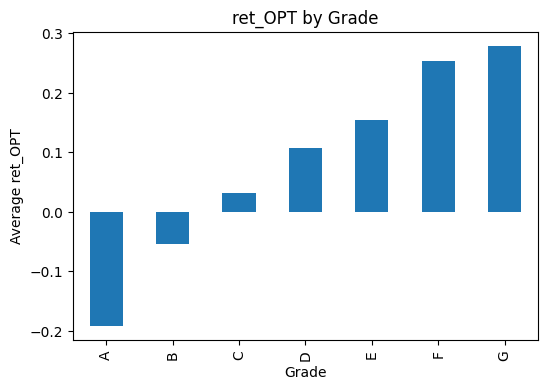


=== Mean ret_INTa by Grade ===
grade
A   -0.074652
B    0.000842
C    0.027549
D    0.037725
E    0.004006
F   -0.044995
G   -0.146953
Name: ret_INTa, dtype: float64


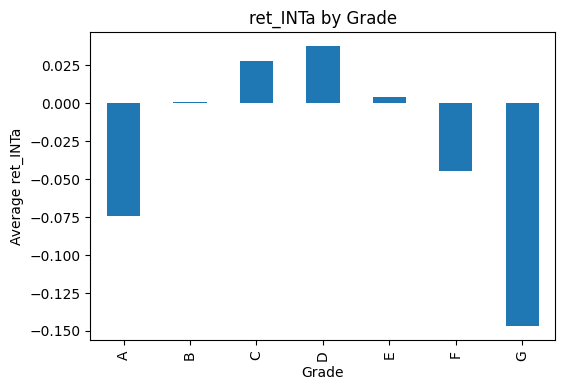


=== Mean ret_INTb by Grade ===
grade
A   -0.069132
B    0.003179
C    0.026451
D    0.034023
E   -0.002665
F   -0.048833
G   -0.149410
Name: ret_INTb, dtype: float64


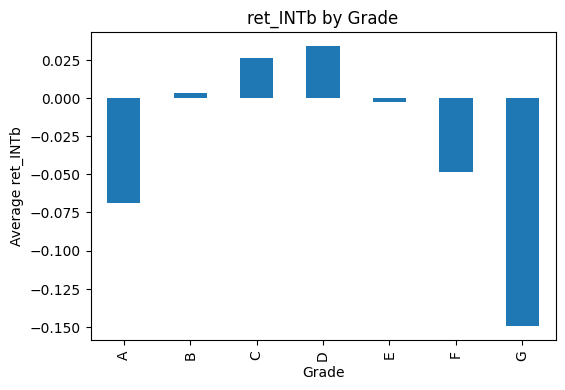


=== Mean ret_INTc by Grade ===
grade
A   -0.060030
B    0.006903
C    0.024577
D    0.027940
E   -0.013361
F   -0.054444
G   -0.152117
Name: ret_INTc, dtype: float64


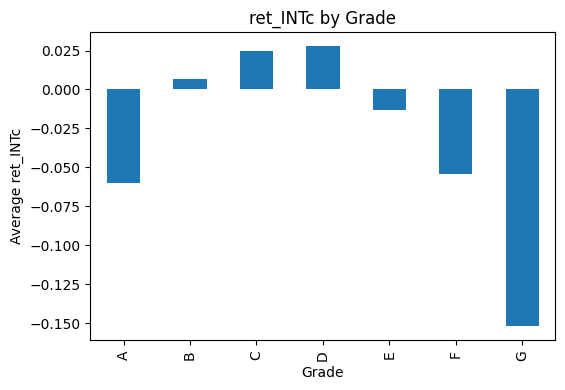

In [ ]:
# RETURNS BY GRADE
return_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

for ret_var in return_cols:
    if ret_var in final_clean_data.columns:
        mean_return_by_grade = final_clean_data.groupby("grade")[ret_var].mean()
        print(f"\n=== Mean {ret_var} by Grade ===")
        print(mean_return_by_grade)

        plt.figure(figsize=(6,4))
        mean_return_by_grade.plot(kind="bar")
        plt.title(f"{ret_var} by Grade")
        plt.ylabel(f"Average {ret_var}")
        plt.xlabel("Grade")
        plt.show()

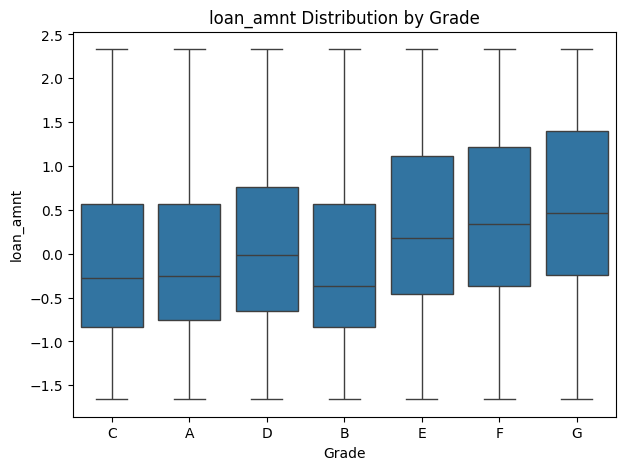

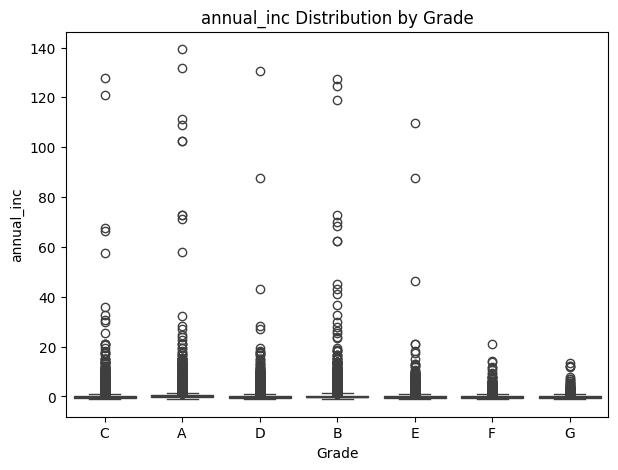

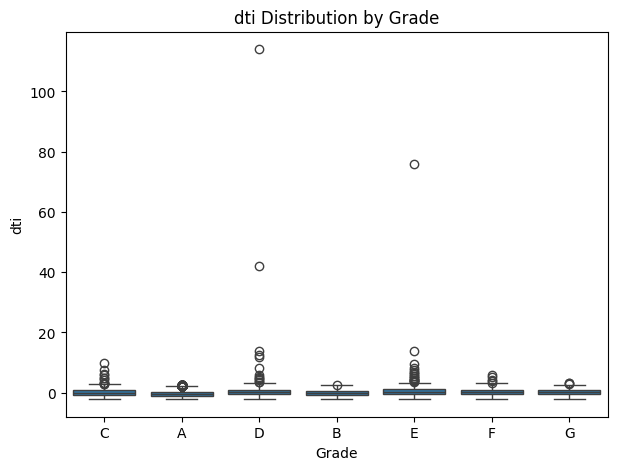

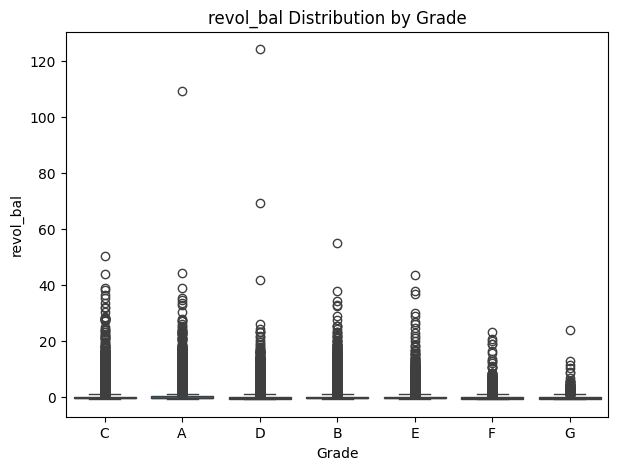

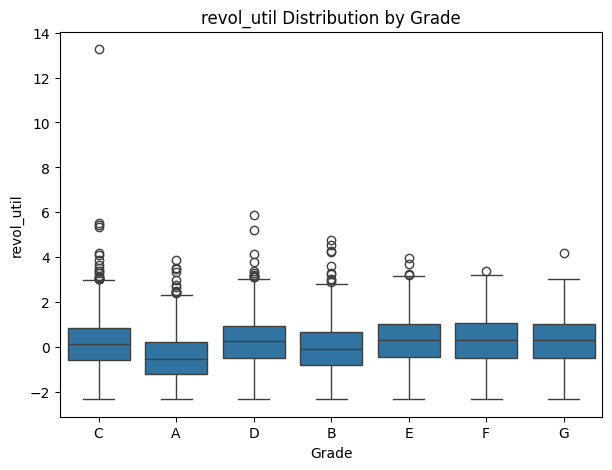


=== Descriptive Stats (Grouped by Grade) ===
      loan_amnt                                                              \
          count      mean       std       min       25%       50%       75%   
grade                                                                         
A      108785.0 -0.058307  0.886938 -1.658947 -0.755283 -0.250640  0.570873   
B      177786.0 -0.125667  0.943169 -1.658947 -0.837435 -0.367999  0.570873   
C      184692.0 -0.052849  1.015802 -1.658947 -0.837435 -0.279980  0.570873   
D      103807.0  0.105867  1.061759 -1.658947 -0.652594 -0.018856  0.764515   
E       53939.0  0.342861  1.053000 -1.658947 -0.456018  0.180654  1.113658   
F       15625.0  0.433256  1.074006 -1.658947 -0.367999  0.333221  1.222215   
G        3715.0  0.590218  1.007451 -1.658947 -0.246239  0.459382  1.398254   

                annual_inc            ... revol_bal             revol_util  \
            max      count      mean  ...       75%         max      count   
grade  

In [ ]:
# NUMERIC FEATURE COMPARISON ACROSS GRADES
num_features = ["loan_amnt", "annual_inc", "dti", "revol_bal", "revol_util"]

for col in num_features:
    if col in final_clean_data.columns:
        plt.figure(figsize=(7,5))
        sns.boxplot(x="grade", y=col, data=final_clean_data)
        plt.title(f"{col} Distribution by Grade")
        plt.xlabel("Grade")
        plt.ylabel(col)
        plt.show()

# Descriptive stats for each numeric feature grouped by grade
desc_stats_by_grade = final_clean_data.groupby("grade")[num_features].describe()
print("\n=== Descriptive Stats (Grouped by Grade) ===")
print(desc_stats_by_grade)

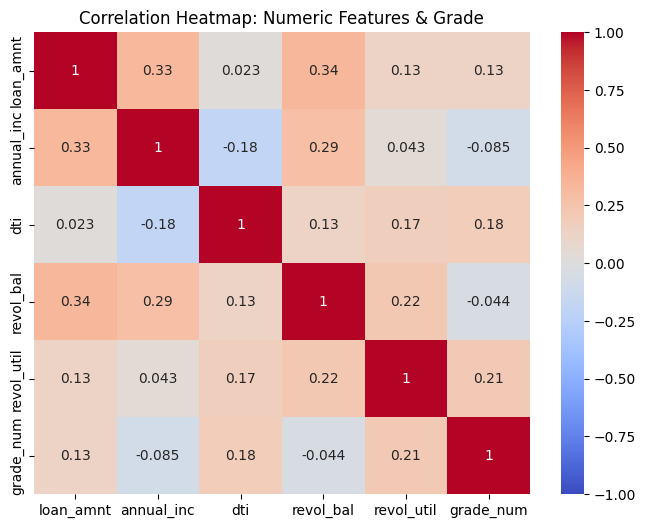

In [ ]:
#  CORRELATIONS BETWEEN GRADE AND NUMERIC FEATURES
grade_map = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7}
final_clean_data["grade_num"] = final_clean_data["grade"].map(grade_map)

# Build correlation matrix with numeric features + the grade_num
corr_cols = num_features + ["grade_num"]
corr_subset = final_clean_data[corr_cols].dropna()  # in case of missing values
corr_matrix = corr_subset.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Numeric Features & Grade")
plt.show()

### K-Means

In [ ]:
# Dropping future indicating columns

cols_to_drop = [
    'grade', 'sub_grade', 'default_ind', 'grade_num',
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',
    'total_pymnt', 'recoveries', 'total_pymnt_log', 'recoveries_log',
    'loan_status_Fully Paid', 'cluster'
]

kmeans_data = final_clean_data.drop(columns=cols_to_drop, errors="ignore")

In [ ]:
# Categorical columns
cat_cols = kmeans_data.select_dtypes(include=["object"]).columns
print("Categorical columns to be one-hot encoded:", list(cat_cols))

Categorical columns to be one-hot encoded: ['term', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']


In [ ]:
#One-hot encoding
kmeans_data_encoded = pd.get_dummies(
    kmeans_data,
    columns=cat_cols,
    drop_first=True
)

print("One-hot encoding complete. New shape:", kmeans_data_encoded.shape)
print("Sample columns:", kmeans_data_encoded.columns[:15])

One-hot encoding complete. New shape: (648349, 51)
Sample columns: Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
       'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'mths_since_last_delinq', 'acc_now_delinq', 'bc_util', 'mort_acc'],
      dtype='object')


In [ ]:
for col in kmeans_data_encoded.columns:
    print(f"{col}: {kmeans_data_encoded[col].dtype}")

loan_amnt: float64
funded_amnt: float64
int_rate: float64
installment: float64
annual_inc: float64
dti: float64
delinq_2yrs: float64
open_acc: float64
pub_rec: float64
revol_bal: float64
revol_util: float64
mths_since_last_delinq: float64
acc_now_delinq: float64
bc_util: float64
mort_acc: float64
num_tl_90g_dpd_24m: float64
pub_rec_bankruptcies: float64
total_bc_limit: float64
loan_length: float64
term_num: float64
term_60 months: bool
emp_length_1 year: bool
emp_length_10+ years: bool
emp_length_2 years: bool
emp_length_3 years: bool
emp_length_4 years: bool
emp_length_5 years: bool
emp_length_6 years: bool
emp_length_7 years: bool
emp_length_8 years: bool
emp_length_9 years: bool
emp_length_< 1 year: bool
home_ownership_MORTGAGE: bool
home_ownership_OWN: bool
home_ownership_RENT: bool
verification_status_Source Verified: bool
verification_status_Verified: bool
loan_status_Fully Paid: bool
purpose_credit_card: bool
purpose_debt_consolidation: bool
purpose_educational: bool
purpose_hom

In [ ]:
kmeans_data_encoded.shape

(648349, 51)

In [ ]:
final_clean_data.shape

(648349, 36)

In [ ]:
#low_var = kmeans_data_encoded.var()[kmeans_data_encoded.var() < 0.001]
#print(low_var)

In [ ]:
#low_variance_cols = kmeans_data_encoded.var()[kmeans_data_encoded.var() < 0.001].index.tolist()
#kmeans_data_encoded = kmeans_data_encoded.drop(columns=low_variance_cols)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

wcss = []
for i in range(1,10):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init=30)
  kmeans.fit(kmeans_data_encoded)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

KeyboardInterrupt: 

In [ ]:
kmeansOpt = KMeans(n_clusters = 7, random_state = 42)
cluster_labels = kmeansOpt.fit_predict(kmeans_data_encoded)

In [ ]:
final_clean_data['cluster'] = cluster_labels

In [ ]:
crossTabGrades = pd.crosstab(final_clean_data['cluster'], final_clean_data['grade'])
print(crossTabGrades)

grade        A      B      C      D      E     F     G
cluster                                               
0        51761  44569  25125   8282   2673   433    59
1         1091   3715   4158   2335   1056   305    63
2        25566  30459  28279  15506   7978  2107   510
3         7073  23085  25646  13631   6218  1598   309
4         1128  16790  40881  36440  27009  9090  2508
5          127    853   1240    756    425   130    40
6        22039  58315  59363  26857   8580  1962   226


### Parallel Coordinates

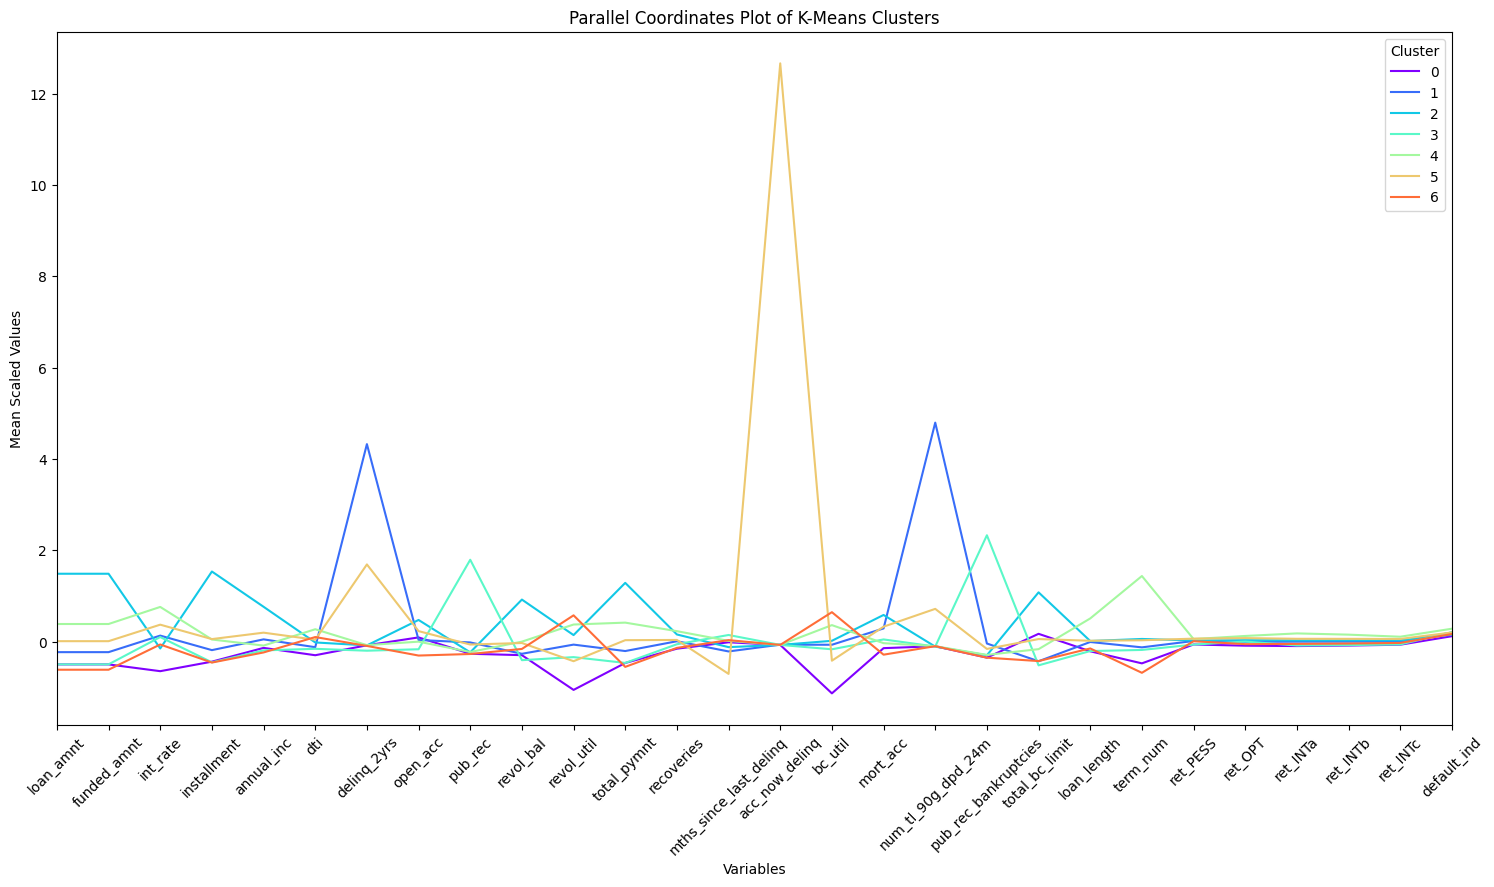

In [ ]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import numpy as np

# 1. Identify numeric columns (excluding the 'cluster' label itself)
numeric_cols = final_clean_data.select_dtypes(include=["float64","int64"]).columns
numeric_cols = numeric_cols.drop("cluster", errors="ignore")

# 2. Compute the mean of each numeric feature for each cluster
df_cluster_means = final_clean_data.groupby("cluster")[numeric_cols].mean().reset_index()

# 3. Plot parallel coordinates using the cluster-aggregated DataFrame
fig, ax = plt.subplots(figsize=(18, 9))

parallel_coordinates(
    df_cluster_means,
    class_column="cluster",
    color=plt.cm.rainbow(np.linspace(0, 1, 8)),
    axvlines=False
)

ax.set_title("Parallel Coordinates Plot of K-Means Clusters")
ax.set_xlabel("Variables")
ax.set_ylabel("Mean Scaled Values")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(title="Cluster")

# Turn off the background grid
ax.grid(False)

plt.show()



### Comparison of K-means clustering with reality

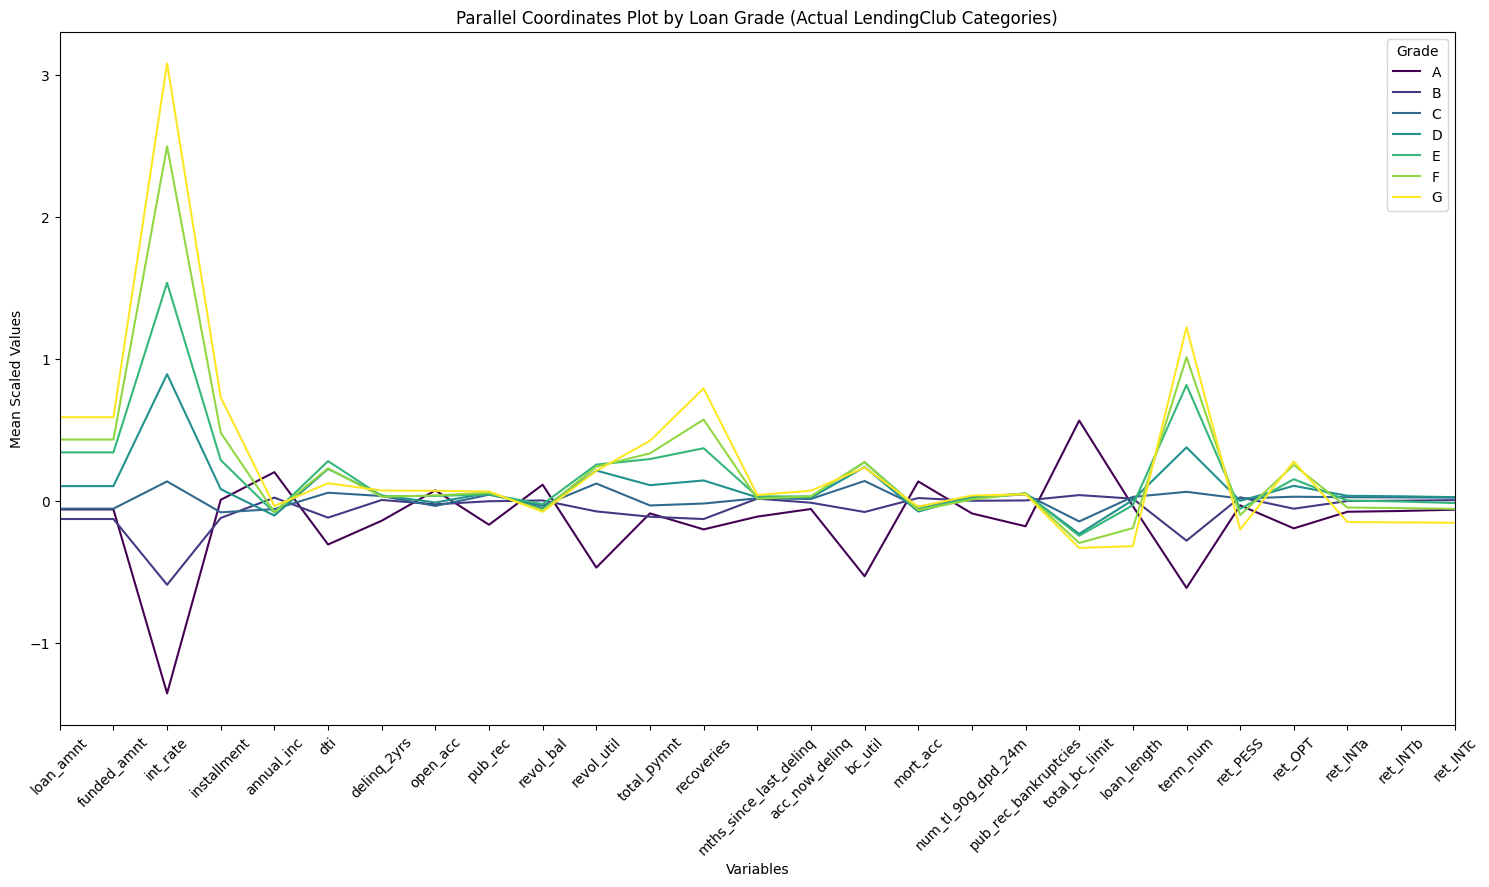

In [ ]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import numpy as np

# 1. Select numeric columns (exclude any that shouldn't be plotted)
numeric_cols = final_clean_data.select_dtypes(include=["float64", "int64"]).columns
numeric_cols = numeric_cols.drop(["cluster", "grade_num", "default_ind"], errors="ignore")

# 2. Compute mean of each numeric feature grouped by GRADE
df_grade_means = final_clean_data.groupby("grade")[numeric_cols].mean().reset_index()

# 3. Plot
fig, ax = plt.subplots(figsize=(18, 9))

parallel_coordinates(
    df_grade_means,
    class_column="grade",
    color=plt.cm.viridis(np.linspace(0, 1, 7)),  # 7 grades: A–G
    axvlines=False
)

ax.set_title("Parallel Coordinates Plot by Loan Grade (Actual LendingClub Categories)")
ax.set_xlabel("Variables")
ax.set_ylabel("Mean Scaled Values")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(title="Grade")

# Remove background grid
ax.grid(False)

plt.show()


### PCA

In [ ]:
pca_data = kmeans_data_encoded.copy()

In [ ]:
pca_data.shape

(648349, 51)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

pca = PCA()
pr_out = pca.fit_transform(pca_data)

[1.77549575e-01 1.00929256e-01 7.72873559e-02 7.50717591e-02
 6.48547782e-02 5.85890104e-02 4.98744527e-02 4.68966572e-02
 4.31562567e-02 3.96483327e-02 3.63048595e-02 2.97861994e-02
 2.36357009e-02 2.17937577e-02 1.68234170e-02 1.62508904e-02
 1.50882196e-02 1.43919216e-02 1.40987471e-02 1.26545545e-02
 9.96501188e-03 6.70768580e-03 6.08227381e-03 5.55773120e-03
 3.88424259e-03 3.81983575e-03 3.76990122e-03 3.47282539e-03
 3.11851357e-03 2.70360570e-03 2.54491702e-03 2.32665216e-03
 2.15868912e-03 2.10008496e-03 1.97217253e-03 1.79189296e-03
 9.69292706e-04 5.47322588e-04 5.22514670e-04 3.88775408e-04
 2.79676271e-04 2.33991104e-04 1.82782276e-04 1.56017346e-04
 3.72434185e-05 1.97012465e-05 8.11060113e-07 6.77500023e-08
 6.77201690e-08 0.00000000e+00 0.00000000e+00]
[0.17754957 0.27847883 0.35576619 0.43083795 0.49569272 0.55428173
 0.60415619 0.65105284 0.6942091  0.73385743 0.77016229 0.79994849
 0.82358419 0.84537795 0.86220137 0.87845226 0.89354048 0.9079324
 0.92203115 0.9346857

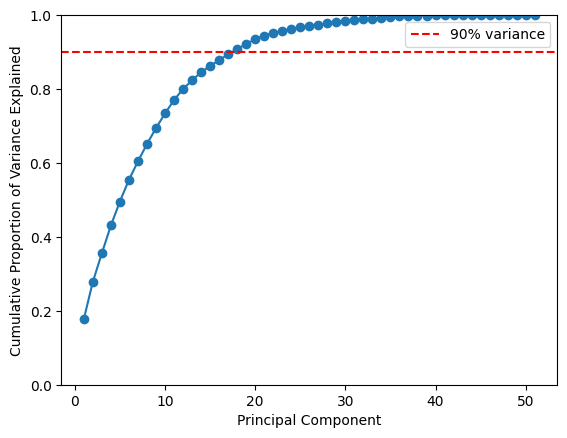

Number of components to explain 90% variance: 18


In [ ]:
# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print(cumulative_variance_ratio)

# Plot cumulative explained variance
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.ylim(0, 1)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.show()

n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"Number of components to explain 90% variance: {n_components_90}")

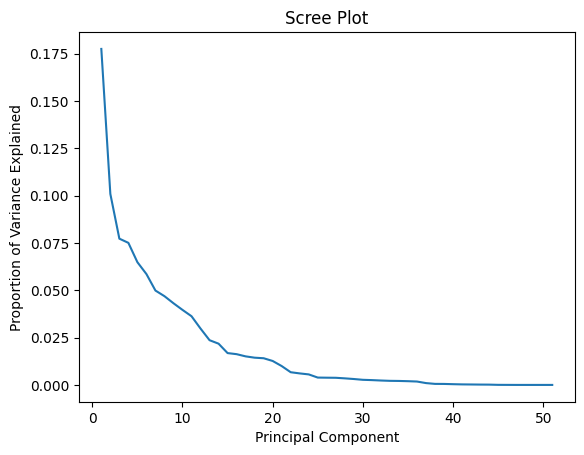

In [ ]:
# Scree Plot
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.grid(False)
plt.show()

In [ ]:
# Index of highest/lowest PC1 values
index_highest_pc1 = np.argmax(pr_out[:, 0])
index_lowest_pc1 = np.argmin(pr_out[:, 0])

# Show full row from original data (optional)
print("Row with highest PC1:")
display(final_clean_data.iloc[index_highest_pc1])

print("Row with lowest PC1:")
display(final_clean_data.iloc[index_lowest_pc1])


Row with highest PC1:


,525132
loan_amnt,2.331257
funded_amnt,2.331257
term,36 months
int_rate,0.816536
installment,3.257132
grade,D
emp_length,10+ years
home_ownership,OWN
annual_inc,4.785773
verification_status,Verified


Row with lowest PC1:


,304223
loan_amnt,-1.025209
funded_amnt,-1.025209
term,36 months
int_rate,0.042053
installment,-0.92553
grade,C
emp_length,1 year
home_ownership,MORTGAGE
annual_inc,-0.565725
verification_status,Verified


In [ ]:
# Biplot Function
def biplot(score, coeff, labels=None, pca=None, top_n=10, scale=3):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 8))
    plt.grid(True, linestyle='--', alpha=0.5)

    # Zoom into dense PCA region
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)

    # Plot PCA scores (lighter points)
    plt.scatter(score[:, 0], score[:, 1], alpha=0.05, color="#D3D3D3", s=5)

    # Select top N contributing features (based on PC1 + PC2 loadings)
    loading_scores = np.sum(coeff**2, axis=1)
    top_indices = np.argsort(loading_scores)[-top_n:]

    # Plot scaled arrows and smaller spaced labels
    for i in top_indices:
        plt.arrow(0, 0,
                  coeff[i, 0] * scale,
                  coeff[i, 1] * scale,
                  color='crimson',
                  alpha=0.8,
                  linewidth=2.0,
                  head_width=0.08,
                  length_includes_head=True)

        if labels is not None:
            plt.text(coeff[i, 0] * scale * 1.2,
                     coeff[i, 1] * scale * 1.2,
                     labels[i],
                     color='darkgreen',
                     ha='center',
                     va='center',
                     fontsize=8)

    # Label axes with variance percentages
    if pca is not None:
        plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}%)")
        plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}%)")
    else:
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    plt.title("PCA Biplot")
    plt.tight_layout()
    plt.show()


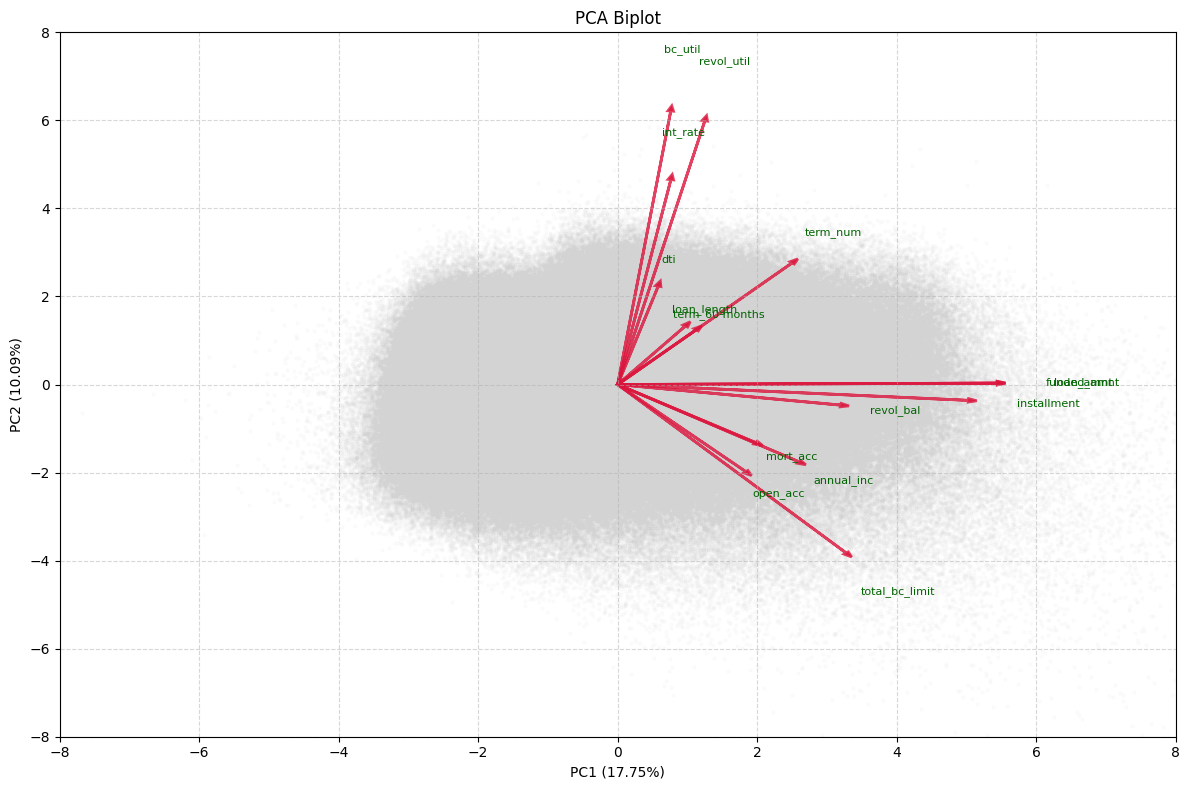

In [ ]:
biplot(
    score=pr_out[:, :2],
    coeff=np.transpose(pca.components_[:2, :]),
    labels=pca_data.columns,
    pca=pca,
    top_n=15,
    scale=12
)